# Exploratory Data Analysis for Spotify Tracks

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## (Down)load data
We are using **Spotify Dataset 1921-2020, 600k+ Tracks** which is build from the Spotify API. Please download the [`tracks.csv` dataset from kaggle, 112 MB](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=tracks.csv) and [`artist.csv` dataset from kaggle, 65 MB](https://www.kaggle.com/datasets/yamaerenay/spotify-dataset-19212020-600k-tracks?select=artists.csv)
... and put both in the `data` folder of the project repository. This notebook should be in the `notebooks` folder of the project repository.

In [80]:
tracks_df = pd.read_csv('../data/tracks.csv')
artists_df = pd.read_csv('../data/artists.csv')

tracks_df.shape, artists_df.shape

((586672, 20), (1162095, 5))

In [81]:
# merge tracks and artist dataframes to add the imortant 'artist_popularity' feature
tracks_df['id_artists'] = [i[2:-2] for i in tracks_df['id_artists']]
artists_df.rename(columns = {'id': 'id_artists','popularity': 'artists_popularity'}, inplace = True)
artists_df.drop(['genres', 'name'],axis = 1, inplace = True)
tracks_df = tracks_df.merge(artists_df, on = 'id_artists')
del artists_df

In [82]:
# convert release date to datetime
tracks_df['release_date'] = pd.to_datetime(tracks_df['release_date'], format = '%Y-%m-%d')
tracks_df['delta_days'] = tracks_df['release_date'].max() - tracks_df['release_date']
tracks_df['delta_days'] = tracks_df['delta_days'].view(dtype = int)

In [83]:
#exclude non-music content
tracks_df = tracks_df[tracks_df['speechiness']<0.66] #above 0.66 are tracks with only spoken words, not music

# drop select columns --> removing all object columns, removing all non-continous
tracks_df = tracks_df.drop(columns=["id", "name", "artists", "id_artists", 
                                    "release_date", "key", 
                                    "time_signature", "key"], axis=1)
tracks_df.dtypes

popularity              int64
duration_ms             int64
explicit                int64
danceability          float64
energy                float64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
followers             float64
artists_popularity      int64
delta_days              int64
dtype: object

In [84]:
tracks_df.head()

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,artists_popularity,delta_days
0,6,126903,0,0.645,0.44500,-13.338,1,0.4510,0.674,0.744,0.1510,0.127,104.851,91.0,4,3128803200000000000
1,0,157333,0,0.298,0.46000,-18.645,1,0.4530,0.521,0.856,0.4360,0.402,87.921,91.0,4,3128803200000000000
2,0,87040,0,0.634,0.00399,-29.973,0,0.0377,0.926,0.919,0.1050,0.396,79.895,91.0,4,3128803200000000000
3,0,40000,0,0.657,0.32500,-14.319,0,0.2540,0.199,0.856,0.0931,0.105,81.944,91.0,4,3128803200000000000
4,0,104400,0,0.644,0.68400,-8.247,1,0.1990,0.144,0.802,0.0847,0.138,100.031,91.0,4,3128803200000000000


In [85]:
# show correlation of popularity with other features in descending order
corr = tracks_df.corr()
corr['popularity'][np.absolute(corr['popularity'])>0.01].sort_values(ascending = False)

popularity            1.000000
artists_popularity    0.567611
loudness              0.281752
energy                0.261373
followers             0.231527
explicit              0.175030
danceability          0.142529
duration_ms           0.069867
tempo                 0.057545
speechiness           0.027401
mode                 -0.016540
liveness             -0.041517
valence              -0.042216
instrumentalness     -0.198077
acousticness         -0.336503
delta_days           -0.566481
Name: popularity, dtype: float64

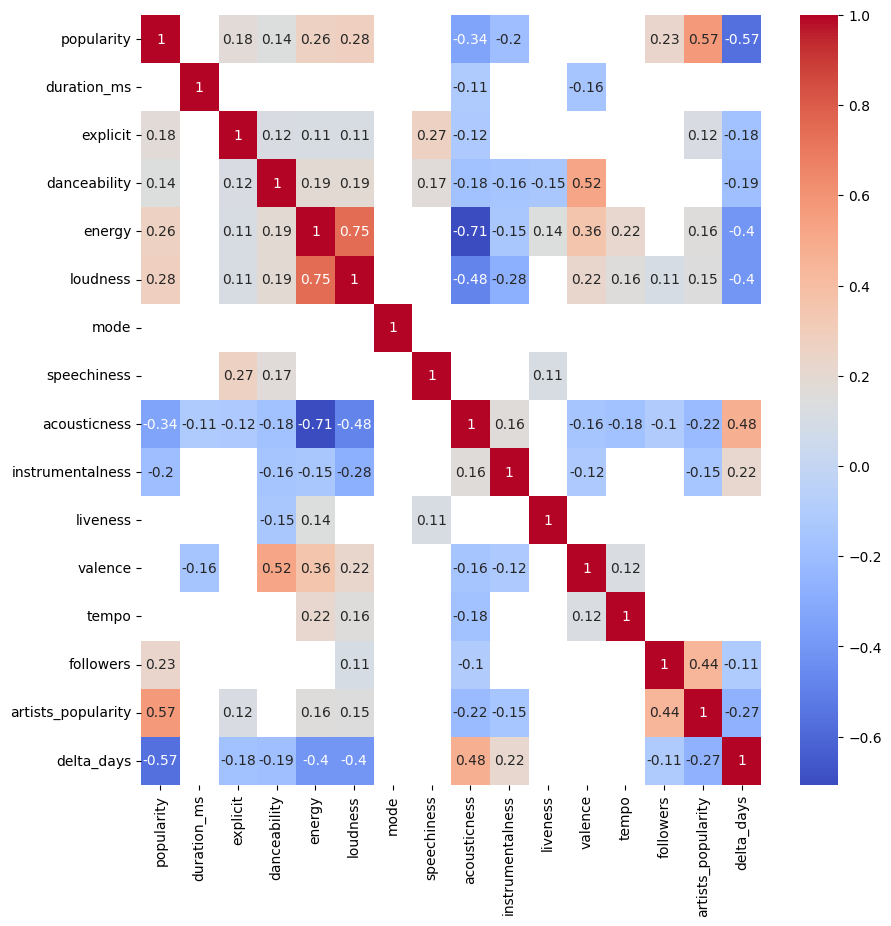

In [86]:
fig, ax = plt.subplots(figsize= (10,10))
sns.heatmap(corr[np.absolute(corr)>0.1], annot = True, cmap='coolwarm')
plt.show()

### Reduce size and memory usage of dataframe for training

In [87]:
# Randomly sample only 10% of the dataset ---> remove this for final training
tracks_min_df = tracks_df.sample(n=int(tracks_df.shape[0]/10))
tracks_df.shape, tracks_min_df.shape

((452017, 16), (45201, 16))

In [88]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings              
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",round(100*mem_usg/start_mem_usg, 2),"% of the initial size")

In [89]:
X = tracks_df.drop(['popularity'], axis = 1)
y = tracks_df['popularity']

X_min = tracks_min_df.drop(['popularity'], axis = 1)
y_min = tracks_min_df['popularity']
reduce_mem_usage(X_min)

Memory usage of properties dataframe is : 5.5177001953125  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  2.715743064880371  MB
This is  49.22 % of the initial size


# Part II: The modeling

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Preprocessing + Training Pipeline

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_min, y_min, test_size = 0.2, random_state = 0)

## Grid Search using XGBoost Regressor on 10% of the data

In [92]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(
    reg_alpha=0.025, 
    reg_lambda=0.05, 
    n_estimators=1000,
    learning_rate=0.1, 
    random_state=0, 
    colsample_bytree=0.6,
    subsample = 0.8,
    max_depth = 20,
    eval_metric = 'rmsle',
    early_stopping_rounds = 10
    )

xgb_reg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmsle', gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=0,
             reg_alpha=0.025, reg_lambda=0.05, ...)

In [93]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test,y_test)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.025, reg_lambda=0.05, ...)

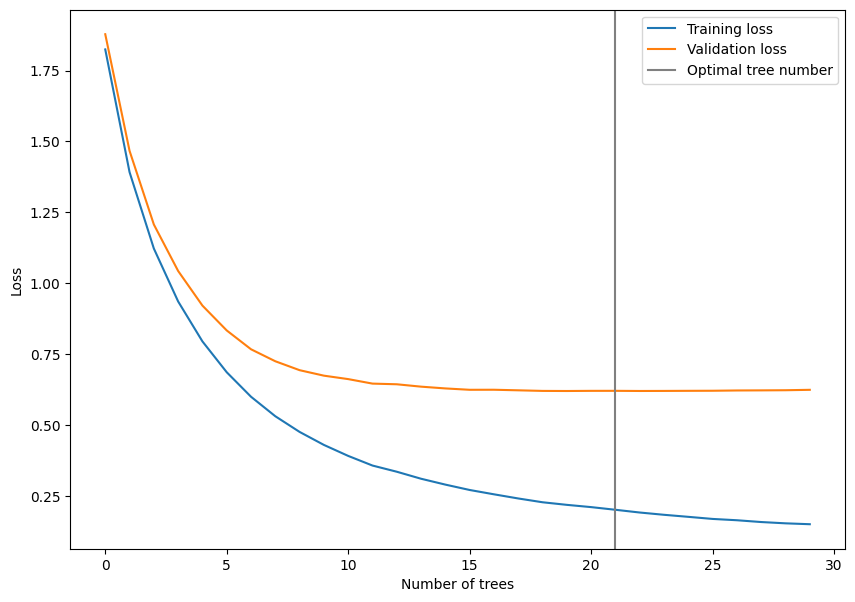

In [94]:
results = xgb_reg.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmsle"], label="Training loss")
plt.plot(results["validation_1"]["rmsle"], label="Validation loss")
plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [95]:
xgb_pred = xgb_reg.predict(X_test,
                           iteration_range=(0, xgb_reg.best_iteration))
    
rmse_xgb = mean_squared_error(y_test, xgb_pred, squared=False)
print("Root Mean Squared Error for XGBoost Regressor:", round(rmse_xgb, 3))

Root Mean Squared Error for XGBoost Regressor: 12.011


In [96]:
print("R2 Score for XGBoost Regressor:", round(r2_score(y_test, xgb_pred), 3))

R2 Score for XGBoost Regressor: 0.53


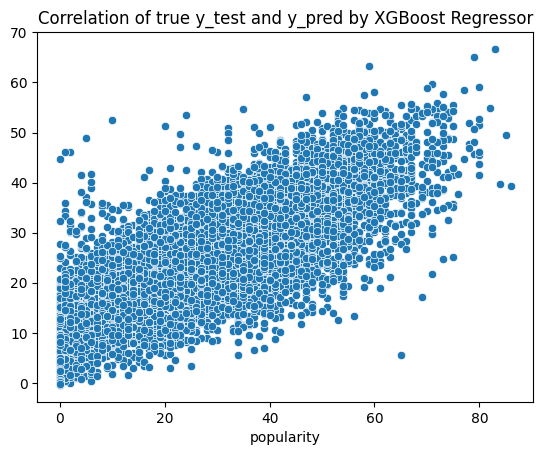

In [97]:
sns.scatterplot(x=y_test, y=xgb_pred)
plt.title("Correlation of true y_test and y_pred by XGBoost Regressor")
plt.show()